## Bribes research
First, calculating different metrics, such as bribe dilutions and $I/O

In [1]:
import math

import pandas as pd
import requests
from IPython.core.display_functions import display

from notebooks.bribes_research.constants import BADGER_LOW_BOUND
from notebooks.bribes_research.constants import BADGER_UPPER_BOUND
from notebooks.bribes_research.constants import BRIBES_URL
from notebooks.bribes_research.constants import DASHBOARD_URL
from notebooks.bribes_research.constants import FEE
from notebooks.bribes_research.constants import POOL_WEIGHTS
from notebooks.bribes_research.constants import PROTOCOL_AURA
from notebooks.bribes_research.constants import PROTOCOL_CVX
from notebooks.bribes_research.constants import REBALANCING_STEP
from notebooks.bribes_research.constants import STEP
from notebooks.bribes_research.constants import TABLE_COLUMNS_COMMON_METRICS
from notebooks.bribes_research.helpers import calculate_metrics
from notebooks.bribes_research.helpers import fetch_token_prices

pd.set_option('display.max_rows', 500)


table_rows = []
average_weighed_metrics = []
cvx_io_metrics = []
aura_io_metrics = []
total_bribes_table = []
badger_price = fetch_token_prices(['badger-dao'])['badger-dao']['usd']

cvx_bribes = requests.post(BRIBES_URL, json={'platform': "votium", 'protocol': "cvx-crv"}).json()
cvx_dash = requests.post(DASHBOARD_URL, json={"id": "bribes-overview-votium"}).json()
aura_bribes = requests.post(BRIBES_URL, json={'platform': "hh", 'protocol': "aura-bal"}).json()
aura_dash = requests.post(DASHBOARD_URL, json={"id": "bribes-overview-aura"}).json()
total_bribes_cvx = sum([bribe['amountDollars'] for bribe in cvx_bribes['epoch']['bribes']])
dollar_spent_on_bribes_cvx = cvx_dash['dashboard']['rewardPerDollarBribe']

total_bribes_aura = sum([bribe['amountDollars'] for bribe in aura_bribes['epoch']['bribes']])
dollar_spent_on_bribes_aura = aura_dash['dashboard']['rewardPerDollarBribe']


for bribe in range(BADGER_LOW_BOUND, BADGER_UPPER_BOUND, STEP):
    badger_bribe_in_dollar = bribe * badger_price
    fees = badger_bribe_in_dollar * FEE
    badger_bribe_in_dollar_after_fees = badger_bribe_in_dollar - fees
    cvx_dilution_50, cvx_in_out_50 = calculate_metrics(badger_bribe_in_dollar_after_fees / 2, total_bribes_cvx,
                                                       dollar_spent_on_bribes_cvx)
    aura_dilution_50, aura_in_out_50 = calculate_metrics(badger_bribe_in_dollar_after_fees / 2, total_bribes_aura,
                                                         dollar_spent_on_bribes_aura)
    # Rebalance here
    cvx_in_out_floating = cvx_in_out_50
    aura_in_out_floating = aura_in_out_50

    cvx_bribe_portion = aura_bribe_portion = badger_bribe_in_dollar_after_fees / 2
    cvx_dilution = None
    aura_dilution = None
    while not math.isclose(cvx_in_out_floating, aura_in_out_floating, abs_tol=0.5):
        # Do not allow negative numbers
        cvx_bribe_portion_percent = round(cvx_bribe_portion / badger_bribe_in_dollar_after_fees * 100, 2)
        aura_bribe_portion_percent = round(aura_bribe_portion / badger_bribe_in_dollar_after_fees * 100, 2)
        # If any of bribe percent is getting closer to 0, break the loop to not go to negative numbers
        if math.isclose(cvx_bribe_portion_percent, 0, abs_tol=0.1) or math.isclose(aura_bribe_portion_percent, 0, abs_tol=0.1):
            break
        if cvx_in_out_floating > aura_in_out_floating:
            # Take bribe portion from aura and give it to cvx
            bribe_stolen = aura_bribe_portion * REBALANCING_STEP
            aura_bribe_portion -= bribe_stolen
            cvx_bribe_portion += bribe_stolen
        elif aura_in_out_floating > cvx_in_out_floating:
            # Take bribe portion from cvx and give it to aura
            bribe_stolen = aura_bribe_portion * REBALANCING_STEP
            cvx_bribe_portion -= bribe_stolen
            aura_bribe_portion += bribe_stolen
        if cvx_bribe_portion <= 0 or aura_bribe_portion <= 0:
            break
        cvx_dilution, cvx_in_out_floating = calculate_metrics(cvx_bribe_portion, total_bribes_cvx,
                                                              dollar_spent_on_bribes_cvx)
        aura_dilution, aura_in_out_floating = calculate_metrics(aura_bribe_portion, total_bribes_aura,
                                                                dollar_spent_on_bribes_aura)
    cvx_percent = round(cvx_bribe_portion / badger_bribe_in_dollar_after_fees * 100, 2)
    aura_percent = round(aura_bribe_portion / badger_bribe_in_dollar_after_fees * 100, 2)

    cvx_in_out_floating_weights = [weight * cvx_in_out_floating for weight in POOL_WEIGHTS]
    aura_in_out_floating_weights = [weight * aura_in_out_floating for weight in POOL_WEIGHTS]

    table_rows.append(
        [PROTOCOL_CVX, bribe, badger_bribe_in_dollar_after_fees, fees, cvx_percent,
         cvx_bribe_portion, cvx_dilution, *cvx_in_out_floating_weights]
    )
    table_rows.append(
        [PROTOCOL_AURA, bribe, badger_bribe_in_dollar_after_fees, fees, aura_percent,
         aura_bribe_portion, aura_dilution, *aura_in_out_floating_weights]
    )
    # Pack Average weighed values into another table
    dollar_io_average_metric = ((cvx_percent / 100) * (cvx_in_out_floating / 100)) + ((aura_percent / 100) * (aura_in_out_floating / 100))
    average_weighed_metrics.append(dollar_io_average_metric)
    cvx_io_metrics.append(cvx_in_out_floating / 100)
    aura_io_metrics.append(aura_in_out_floating / 100)
    total_bribes_table.append(badger_bribe_in_dollar_after_fees)

## $I/O Results

In [2]:
dataframe = pd.DataFrame(data=table_rows, columns=TABLE_COLUMNS_COMMON_METRICS)
display(dataframe)

,Market,BADGER bribe,Total bribe in $,Fees,Bribes Portion %,Bribes Portion,Dilution,$I/O 50%,$I/O 60%,$I/O 80%,$I/O 100%
0,CVX,2000,6950.4,289.6,0.10,7.229110,0.000244,60.916188,73.099425,97.465900,121.832375
1,AURA,2000,6950.4,289.6,99.90,6943.170890,2.247409,83.442886,100.131463,133.508617,166.885772
2,CVX,4000,13900.8,579.2,0.10,14.458219,0.000487,60.916039,73.099247,97.465663,121.832078
3,AURA,4000,13900.8,579.2,99.90,13886.341781,4.494817,81.524469,97.829362,130.439150,163.048937
4,CVX,6000,20851.2,868.8,0.10,21.687329,0.000731,60.915891,73.099069,97.465425,121.831782
5,AURA,6000,20851.2,868.8,99.90,20829.512671,6.742226,79.606051,95.527262,127.369682,159.212103
6,CVX,8000,27801.6,1158.4,0.10,28.916439,0.000974,60.915743,73.098891,97.465188,121.831485
7,AURA,8000,27801.6,1158.4,99.90,27772.683561,8.989634,77.687634,93.225161,124.300215,155.375268
8,CVX,10000,34752.0,1448.0,0.10,36.145549,0.001218,60.915594,73.098713,97.464951,121.831188
9,AURA,10000,34752.0,1448.0,99.90,34715.854451,11.237043,75.769217,90.923060,121.230747,151.538434


## Displaying $I/O metric for latest bribes round on both Votium and HH combined

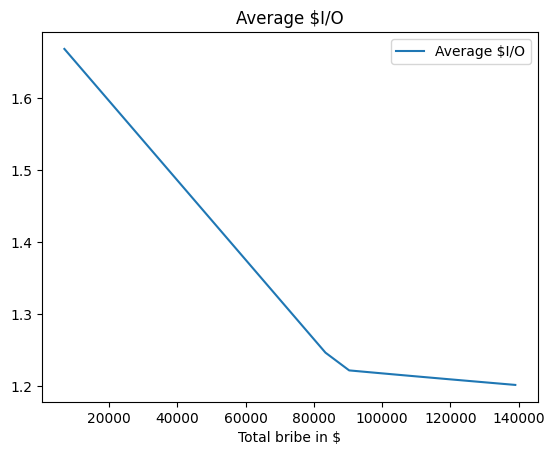

In [3]:
df = pd.DataFrame({
    'Total bribe in $': total_bribes_table,
   'Average $I/O': average_weighed_metrics,
   })
lines = df.plot.line(x="Total bribe in $", y='Average $I/O', title="Average $I/O")

## Displaying $I/O metric for latest bribes round on both Votium and HH separately

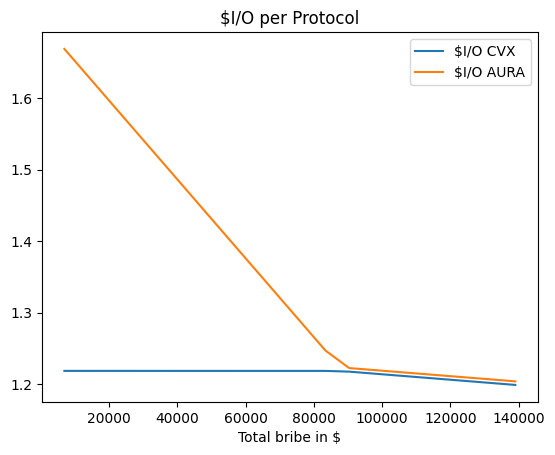

In [4]:
df = pd.DataFrame({
    'Total bribe in $': total_bribes_table,
   '$I/O CVX': cvx_io_metrics,
   '$I/O AURA': aura_io_metrics,
   })
lines_breakdown = df.plot.line(x="Total bribe in $", title="$I/O per Protocol")